In [ ]:
# default_exp core

# gaitplotlib

> Plot sequences of poses with minimal effort

## To Do

1. ~~Strip out chumpy from SMPLH files~~
3. ~~Load SMPL-H instead of SMPL~~~
4. ~~Plot matplotlib animation~~
5. ~~nbdevify example code~~
6. ~~carve out functions for export~~

In [ ]:
# hide
from nbdev.showdoc import *

Imports required by the library:

In [ ]:
# export
import shutil
from pathlib import Path
import numpy as np
import os
import pickle
import torch

Imports required for testing:

In [ ]:
import tempfile

## Load Sample Data

This data is going to be used for testing and examples.

In [ ]:
with tempfile.TemporaryDirectory() as tmpdirname:
    shutil.unpack_archive("sample_data/sample.tar.bz2", extract_dir=tmpdirname)
    for npz_loc in (Path(tmpdirname) / "sample" / "subdir").glob("*.npz"):
        if "amass" in npz_loc.name:
            print(f"loading from {npz_loc}")
            data = np.load(npz_loc)

loading from /tmp/tmpi6yo8887/sample/subdir/amass_sample.npz


In [ ]:
for k in data.keys():
    print(k)

poses
gender
mocap_framerate
betas
marker_data
dmpls
marker_labels
trans


## Unpacking Body Models

> AMASS uses the SMPL-H human body model, this unpacks it into a standard directory structure.

To run this you need to have downloaded the SMPL-H model archive from the [MANO webpage][mano].

Unfortunately, I can't include this in the repository for two reasons:

1. It's over 100MB
2. I would be breaking the model license

So, this notebook won't execute any tests or generate results unless explicitly enabled locally.

[mano]: https://mano.is.tue.mpg.de/

In [ ]:
model_folder = Path("body_models")

In [ ]:
# exports


def unpack_smpl(smpl_dir):
    """`smplx.create` expects pkl files to be in SMPL directory,
    but this is not the structure of unzipped SMPL archives.
    This function fixes that."""
    for pkl_file in smpl_dir.glob("smpl/models/*.pkl"):
        target = smpl_dir / "smpl" / pkl_file.name
        if not target.exists():
            print(pkl_file, "-> ", target)
            os.rename(pkl_file, target)

In [ ]:
# smplh
unpack_smpl(model_folder)

In [ ]:
# exports


def unpack_smplh(smplh_dir):
    """`smplx.create` expects pkl files to be in `smplh` directory"""
    # unpack `smplh.tar.xz`
    target = smplh_dir / "smplh"
    archive_file = smplh_dir / "smplh.tar.xz"
    if not target.exists():
        target.mkdir(exist_ok=True)
        shutil.unpack_archive(archive_file, extract_dir=target)
    for gender in ["male", "female", "neutral"]:
        subdir = target / gender
        for model_loc in subdir.glob("*.npz"):
            smplx_expects = target / f"SMPLH_{gender.upper()}.npz"
            os.rename(model_loc, smplx_expects)
            print(f"{model_loc} -> {smplx_expects}")
    return [p for p in target.glob("*.npz")]

In [ ]:
# smplh
_ = unpack_smplh(model_folder)

In [ ]:
# exports


def unpack_smplh_from_mano(smplh_dir, use_smplh_archive=True):
    # unpack mano_v1_2.zip
    for archive_file in smplh_dir.glob("mano*.zip"):
        target = smplh_dir / archive_file.name.split(".")[0]
        if not target.exists():
            shutil.unpack_archive(archive_file, extract_dir=smplh_dir)
        model_dir = target / "models"
        smplh_locs, output_fns = [], {}
        for mano_file in model_dir.glob("*.pkl"):
            if "LEFT" in mano_file.name:
                mano_left_fn = mano_file
            elif "RIGHT" in mano_file.name:
                mano_right_fn = mano_file
            elif "SMPLH" in mano_file.name:
                smplh_locs.append(mano_file)
                output = mano_file.name.split(".")[0] + ".npz"
                output_fns[mano_file.name] = smplh_dir / "smplh" / output

    if use_smplh_archive:
        smplh_locs = unpack_smplh(smplh_dir)
        for p in smplh_locs:
            output_fns[p.name] = p

    # merge MANO and SMPLH file
    for smplh_fn in smplh_locs:

        def pkl_load(pkl_file):
            try:
                with open(pkl_file, "rb") as f:
                    return pickle.load(f)
            except UnicodeDecodeError:
                with open(pkl_file, "rb") as f:
                    u = pickle._Unpickler(f)
                    u.encoding = "latin1"
                    return u.load()

        if smplh_fn.name.split(".")[1] == "npz":
            body_data = np.load(smplh_fn)
            output_data = {k: body_data[k] for k in body_data}
        elif smplh_fn.name.split(".")[1] == "pkl":
            body_data = pkl_load(smplh_fn)
            output_data = body_data.copy()
        lhand_data = pkl_load(mano_left_fn)
        rhand_data = pkl_load(mano_right_fn)

        output_data["hands_componentsl"] = lhand_data["hands_components"]
        output_data["hands_componentsr"] = rhand_data["hands_components"]

        output_data["hands_coeffsl"] = lhand_data["hands_coeffs"]
        output_data["hands_coeffsr"] = rhand_data["hands_coeffs"]

        output_data["hands_meanl"] = lhand_data["hands_mean"]
        output_data["hands_meanr"] = rhand_data["hands_mean"]

        for key, data in output_data.items():
            if "chumpy" in str(type(data)):
                output_data[key] = np.array(data)
            else:
                output_data[key] = data

        class Struct(object):
            def __init__(self, **kwargs):
                for key, val in kwargs.items():
                    setattr(self, key, val)

        _struct = Struct(**output_data)
        assert hasattr(_struct, "shapedirs")

        print(
            f"Saving to data with keys {[k for k in output_data.keys()]} to {smplh_fn}"
        )
        np.savez(output_fns[smplh_fn.name], **output_data)

In [ ]:
# smplh
unpack_smplh_from_mano(model_folder)

Saving to data with keys ['J_regressor_prior', 'f', 'J_regressor', 'kintree_table', 'J', 'weights_prior', 'weights', 'posedirs', 'bs_style', 'v_template', 'shapedirs', 'bs_type', 'hands_componentsl', 'hands_componentsr', 'hands_coeffsl', 'hands_coeffsr', 'hands_meanl', 'hands_meanr'] to body_models/smplh/SMPLH_MALE.npz
Saving to data with keys ['J_regressor_prior', 'f', 'J_regressor', 'kintree_table', 'J', 'weights_prior', 'weights', 'posedirs', 'bs_style', 'v_template', 'shapedirs', 'bs_type', 'hands_componentsl', 'hands_componentsr', 'hands_coeffsl', 'hands_coeffsr', 'hands_meanl', 'hands_meanr'] to body_models/smplh/SMPLH_NEUTRAL.npz
Saving to data with keys ['J_regressor_prior', 'f', 'J_regressor', 'kintree_table', 'J', 'weights_prior', 'weights', 'posedirs', 'bs_style', 'v_template', 'shapedirs', 'bs_type', 'hands_componentsl', 'hands_componentsr', 'hands_coeffsl', 'hands_coeffsr', 'hands_meanl', 'hands_meanr'] to body_models/smplh/SMPLH_FEMALE.npz


In [ ]:
# exports


def canonical_smpl_names(smpl_dir):
    "Canonical naming convention for SMPL body model files"
    for pkl_file in smpl_dir.glob("smpl/*.pkl"):
        gender = {"f": "FEMALE", "m": "MALE", "neutral": "NEUTRAL"}[
            pkl_file.name.split("_")[1]
        ]
        target = smpl_dir / "smpl" / f"SMPL_{gender}.pkl"
        if not target.exists():
            print(pkl_file, "->", target)
            os.rename(pkl_file, target)

In [ ]:
# smplh
canonical_smpl_names(model_folder)

### Symbolic Link

> The library will need to know where to look for the body models later, so create a symbolic link.

Creating a symbolic link in the user's `~/.config` directory that will point to wherever the body models have been unpacked. The library can then look for the unpacked body model files at that location.

In [ ]:
# exports


def create_bmlink(bmloc):
    dotconfig = Path.home() / ".config/gaitplotlib"
    dotconfig.mkdir(parents=True, exist_ok=True)
    dst = dotconfig / bmloc.name
    if dst.is_symlink():  # always overwrite
        dst.unlink()
    print(f"Creating symlink to {bmloc} at {dst}")
    os.symlink(bmloc.absolute(), dst)

In [ ]:
# smplh

for bmloc in model_folder.glob("smplh/*.npz"):
    create_bmlink(bmloc)
linkloc = Path.home() / ".config/gaitplotlib/SMPLH_NEUTRAL.npz"
_ = np.load(linkloc)

Creating symlink to body_models/smplh/SMPLH_MALE.npz at /home/gngdb/.config/gaitplotlib/SMPLH_MALE.npz
Creating symlink to body_models/smplh/SMPLH_NEUTRAL.npz at /home/gngdb/.config/gaitplotlib/SMPLH_NEUTRAL.npz
Creating symlink to body_models/smplh/SMPLH_FEMALE.npz at /home/gngdb/.config/gaitplotlib/SMPLH_FEMALE.npz


### Console Script

> Definition for a console script that performs the unpacking from the command line.



In [ ]:
# exports

import argparse


def console_unpack():
    parser = argparse.ArgumentParser(
        description="Unpack SMPL and SMPL-H body model archives."
    )
    parser.add_argument("bmdir", type=str, help="Body model directory.")
    parser.add_argument(
        "type",
        type=str,
        choices=["smpl", "smplh"],
        help="Choose between SMPL and SMPL-H",
    )
    args = parser.parse_args()
    bmdir = Path(args.bmdir)
    if args.smpl:
        unpack_smpl(bmdir)
        canonical_smpl_names(bmdir)
        for bmloc in bmdir.glob("smpl/*.npz"):
            create_bmlink(bmloc)
    elif args.smplh:
        unpack_smplh(bmdir)
        manoloc = next(bmdir.glob("mano*.zip"))
        if Path(manoloc).exists():
            unpack_smplh_from_mano(bmdir)
        for bmloc in bmdir.glob("smplh/*.npz"):
            create_bmlink(bmloc)

## Plotting Using `human_body_prior`

> Building on the AMASS demo to plot poses



The [AMASS demos][demo] demonstrate how to use the body models in [human_body_prior][hbp] to plot poses. I'm going to use that code there to plot poses in matplotlib.

[hbp]: https://github.com/nghorbani/human_body_prior
[demo]: https://github.com/nghorbani/amass/tree/master/notebooks

### Extract Joints, Vertices and Faces

> Functions to load absolute 3D joint locations, vertices and faces for plotting

In [ ]:
# exports
from human_body_prior.body_model.body_model import BodyModel


def init_body_model(subject_gender, num_betas=16, num_dmpls=8):
    bm_fname = Path.home() / f".config/gaitplotlib/SMPLH_{subject_gender.upper()}.npz"
    assert bm_fname.is_symlink()
    return BodyModel(bm_fname=str(bm_fname), num_betas=num_betas)

### Plottable Parameters

> This is the main function that maps from pose angles to plottable parameters.

In [ ]:
# exports
def sample_betas(num_betas=16, seed=None):
    rng = np.random.RandomState(seed)
    return rng.randn(1, num_betas).astype(np.float32)


def plottable(pose_angles, betas=None, gender="neutral"):
    """Turn a vector or a batch of pose_angles from
    a set of angles into plottable coordinates in 3D space."""
    # if betas are not passed, sample a random body shape
    if betas is None:
        # seed so the same poses will get the same body shape
        seed = np.sum(np.abs(pose_angles * 100).astype(int))
        betas = sample_betas(seed=seed)

    time_length = len(pose_angles)
    # map to tensors for body model module
    body_parms = {
        "betas": betas.reshape(1, -1).repeat(time_length, 0),
        "root_orient": pose_angles[:, :3],
        "pose_body": pose_angles[:, 3:66],
        "pose_hand": pose_angles[:, 66:],
    }
    body_parms = {k: torch.tensor(body_parms[k]).float() for k in body_parms}

    # initialise body model
    bm = init_body_model(gender)
    # forward pass for body_pose
    with torch.no_grad():
        body_pose = bm(**body_parms)

    # struct that can be indexed
    class IndexStruct:
        def __init__(self, **kwargs):
            self.keys = []
            for k, v in kwargs.items():
                self.keys.append(k)
                setattr(self, k, v)

        def __getitem__(self, i):
            # only index variables with a batch dimension
            v = {k: getattr(self, k)[i] for k in ["vertices", "joints"]}
            # dictionary union
            return dict(v, **{k: getattr(self, k) for k in set(self.keys) - set(v)})

        def __repr__(self):
            return "\n".join([f"{k}: {getattr(self, k).shape}" for k in self.keys])

    return IndexStruct(
        vertices=body_pose.v,
        joints=body_pose.Jtr,
        faces=body_pose.f,
        skeleton=bm.kintree_table.T[1:],
    )

In [ ]:
# smplh
pose_angles = data["poses"]
plottable_params = plottable(pose_angles)

### Plotting with Matplotlib

In [ ]:
# smplh
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import io
import mediapy as media
from tqdm.auto import tqdm

In [ ]:
def plot_pose(vertices, joints, faces, skeleton, DPI=100):
    def to_numpy(x):
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()

    vertices, joints = to_numpy(vertices), to_numpy(joints)

    size = 16
    fig = plt.figure(dpi=DPI, tight_layout=True)
    for i in range(2):
        ax = fig.add_subplot(121 + i, projection="3d")
        # ax.view_init(110, -90)
        ax.view_init(0, 45 * i)
        mesh = Poly3DCollection(vertices[faces[:, [0, 1, 2]]], alpha=0.1)
        face_color = (1.0, 1.0, 0.9)
        edge_color = (0, 0, 0)
        # mesh.set_edgecolor(edge_color)
        # mesh.set_facecolor(face_color)
        ax.add_collection3d(mesh)
        j = joints
        ax.scatter(j[:25, 0], j[:25, 1], j[:25, 2], color="r", s=0.1)
        for bone in skeleton:
            a = j[bone[0]]
            b = j[bone[1]]
            x, y, z = list(zip(a, b))
            ax.plot(x, y, z, color="r", alpha=0.5)

    # saving figure to buffers to create an animation is inefficient
    # but it means I don't have to use matplotlib's built-in animation renderer
    # which would involve rewriting all the plotting code
    io_buf = io.BytesIO()
    fig.savefig(io_buf, format="rgba", dpi=DPI)
    io_buf.seek(0)
    img_arr = np.reshape(
        np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
        newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1),
    )
    io_buf.close()
    plt.clf()
    plt.close()

    return img_arr


class Trimmer:
    def __init__(self, img):
        self.trim(img, init=True)

    def trim(self, img, init=False):
        """Matplotlib creates massive whitespace, this trims it."""
        img = img[:, :, :3]
        if init:
            m = (img < 240).all(2)

            def edges(x):
                "argmax returns the first max value so the first True in a 1D bool array"
                return x.argmax(), len(x) - x[::-1].argmax()

            xmin, xmax = edges(m.any(1))
            ymin, ymax = edges(m.any(0))
            self.trim_to = (xmin, xmax, ymin, ymax)
        else:
            xmin, xmax, ymin, ymax = self.trim_to
        return img[xmin:xmax, ymin:ymax]

In [ ]:
# smplh
gifloc = Path("images/example.gif")

In [ ]:
# smplh
img_arrs = []
trimmer = None
for i in tqdm(range(0, len(plottable_params.vertices), 20)):
    img_arr = plot_pose(**plottable_params[i])
    if trimmer is None:
        trimmer = Trimmer(img_arr)
    img_arrs.append(trimmer.trim(img_arr))
video = np.stack(img_arrs)
gifloc.parent.mkdir(parents=True, exist_ok=True)
media.write_video(gifloc, video, codec="gif", fps=15)

  0%|          | 0/31 [00:00<?, ?it/s]

""

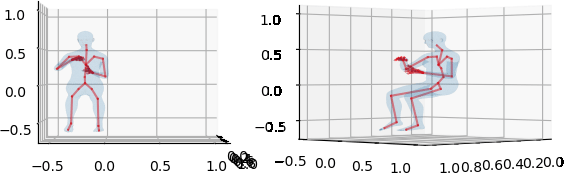

In [ ]:
# smplh
media.show_video(media.read_video(gifloc), codec="gif", fps=15)

## SMPL-H Joint Names

> Access the SMPL-H Joint Names.

I don't know where else this is available in the MPI documentation. I found it [hidden in the SMPLX code](https://github.com/vchoutas/smplx/blob/master/smplx/joint_names.py#L166-L240).

In [ ]:
# exports
import smplx.joint_names

SMPLH_JOINT_NAMES = smplx.joint_names.SMPLH_JOINT_NAMES

In [ ]:
for i, j in enumerate(SMPLH_JOINT_NAMES):
    print(i, j)

0 pelvis
1 left_hip
2 right_hip
3 spine1
4 left_knee
5 right_knee
6 spine2
7 left_ankle
8 right_ankle
9 spine3
10 left_foot
11 right_foot
12 neck
13 left_collar
14 right_collar
15 head
16 left_shoulder
17 right_shoulder
18 left_elbow
19 right_elbow
20 left_wrist
21 right_wrist
22 left_index1
23 left_index2
24 left_index3
25 left_middle1
26 left_middle2
27 left_middle3
28 left_pinky1
29 left_pinky2
30 left_pinky3
31 left_ring1
32 left_ring2
33 left_ring3
34 left_thumb1
35 left_thumb2
36 left_thumb3
37 right_index1
38 right_index2
39 right_index3
40 right_middle1
41 right_middle2
42 right_middle3
43 right_pinky1
44 right_pinky2
45 right_pinky3
46 right_ring1
47 right_ring2
48 right_ring3
49 right_thumb1
50 right_thumb2
51 right_thumb3
52 nose
53 right_eye
54 left_eye
55 right_ear
56 left_ear
57 left_big_toe
58 left_small_toe
59 left_heel
60 right_big_toe
61 right_small_toe
62 right_heel
63 left_thumb
64 left_index
65 left_middle
66 left_ring
67 left_pinky
68 right_thumb
69 right_index
70

In [ ]:
from nbdev.export import notebook2script

notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.
